In [1]:
import numpy as np
import pandas as pd
import pickle
from utils import load_CPS_data, decompose_Y, generate_simulation_components, parallel_experiments

In [2]:
data_dict = {}
RMSE = {}
bias = {}

# set n_jobs to the number of cores
num_cores = 36
num_experiments = 1000

## Load and Format Data

In [4]:
configs = {'Baseline': ['log_wage', 'min_wage', None],
            'Gun Law': ['log_wage', 'open_carry', None],
            'Abortion': ['log_wage', 'abort_ban', None],
            'Random': ['log_wage', 'min_wage', 'Random'],
            'Hours': ['hours', 'min_wage', None],
            'U-rate': ['urate', 'min_wage', None],
            'No Corr':['log_wage', 'min_wage', 'No Corr'],
            'No M': ['log_wage', 'min_wage', 'No M'],
            'No F': ['log_wage', 'min_wage', 'No F'],
            'Only Noise': ['log_wage', 'min_wage', 'Only Noise'],
            'No Noise': ['log_wage', 'min_wage', 'No Noise'],
            'T_post=1': ['log_wage', 'min_wage', 'T_post=1'],
            'N_tr=1': ['log_wage', 'min_wage', 'N_treated=1'],
            'T_post=N_tr=1': ['log_wage', 'min_wage', 'T_post=N_tr=1']}

TROP_dict = {'Baseline': [0.01, 0.2, 0.2],
            'Gun Law':  [0, 0.35, 0.041],
            'Abortion': [0, 0.2, 0.281],
            'Random': [0, 0.2, 0.21],
            'Hours': [1.8, 0.2, 0.031],
            'U-rate': [1.6, 0.35, 0.011],
            'No Corr':[0.7, 0.25, 0.6],
            'No M': [0.1, 0.025, 0.121],
            'No F': [1.4, 0.25, 0.301],
            'Only Noise': [1.8, 0.005, 0.4],
            'No Noise': [5.8, 1.2, 0.21],
            'T_post=1': [1.8, 0.5, 0.321],
            'N_tr=1': [4.5, 0.2, 0.011],
            'T_post=N_tr=1': [0.9, 0.04, 0.301]}

for setting, config in configs.items():
    
    print(setting)
    
    # load and process data for each setting
    outcome, treatment, option = config
    data = load_CPS_data(outcome, treatment)
    data_dict[setting] = data
    
    # run simulations
    simulation_components = generate_simulation_components(data)
    np.random.seed(0)
    RMSE[setting], bias[setting] = parallel_experiments(num_cores, num_experiments, simulation_components, TROP_dict[setting], option)

# save output to table
pd.DataFrame({'setting': RMSE.keys(), 'RMSE': RMSE.values()}).to_csv('RMSE.csv')
# save data and TROP parameters for reference
with open('table_4_processed_data.pkl', 'wb') as file:
    pickle.dump(data_dict, file)
with open('table_4_TROP_params.pkl', 'wb') as file:
    pickle.dump(TROP_dict, file)

Baseline
Gun Law
Abortion
Random
Hours
U-rate
No Corr
No M
No F
Only Noise
No Noise
T_post=1
N_tr=1
T_post=N_tr=1


In [5]:
RMSE

{'Baseline': array([0.02577332, 0.02927782, 0.03716681, 0.04910175, 0.03220029,
        0.03154781]),
 'Gun Law': array([0.02374691, 0.02734513, 0.02672617, 0.04836394, 0.03164512,
        0.03123434]),
 'Abortion': array([0.02203551, 0.02510486, 0.0314178 , 0.04382877, 0.02740282,
        0.02735994]),
 'Random': array([0.02267736, 0.0253971 , 0.02492984, 0.04423942, 0.02775045,
        0.02657616]),
 'Hours': array([0.16666944, 0.19904193, 0.20407271, 0.20842909, 0.18538248,
        0.20024313]),
 'U-rate': array([0.2031808 , 0.21397748, 0.22558389, 0.38424902, 0.22340464,
        0.22093483]),
 'No Corr': array([0.02738207, 0.02929132, 0.03735492, 0.04909923, 0.03282043,
        0.03206474]),
 'No M': array([0.01514238, 0.01848404, 0.01816194, 0.01347714, 0.01468009,
        0.01669911]),
 'No F': array([0.02560653, 0.02933425, 0.02229052, 0.04910175, 0.03220028,
        0.03154781]),
 'Only Noise': array([0.01464086, 0.01847685, 0.01447359, 0.01347714, 0.0146801 ,
        0.0166991

# Optimal Tuning Parameter

In [13]:
from methods import TROP_TWFE_average
from utils import generate_data
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

In [14]:
np.random.seed(1)
outcome, treatment, option = ['log_wage', 'min_wage', None]
data = load_CPS_data(outcome, treatment)
F, M, cov_mat, pi = generate_simulation_components(data)

In [15]:
Y_true, _, treated_units, _ = generate_data(F, M, cov_mat, pi, option)
treated_periods = 10
treated_unit_number = 10

In [108]:
def get_ATE(trial, Y_true_full, lambda_unit, lambda_time, lambda_nn):
    np.random.seed(trial)
    Y_true, _, treated_units, _ = generate_data(F, M, cov_mat, pi, option)
    
    Y_true = np.delete(Y_true_full, treated_units, axis=0)
    N_total, _ = Y_true.shape
    test_units = np.random.choice(np.arange(N_total), size=treated_unit_number,replace=False)
    
    W_test = np.zeros(Y_true.shape)
    W_test[test_units,-treated_periods:] = 1
    estimate = TROP_TWFE_average(Y_true,W_test, test_units,lambda_unit=lambda_unit,lambda_time=lambda_time,lambda_nn=lambda_nn)
    return estimate

## Select lambda_unit

In [ ]:
Q = []
lambda_units = np.arange(0,4,4/10)
for lambda_unit in lambda_units:
    lambda_time = 0.1
    lambda_nn = 0.9
    print(lambda_unit,lambda_time,lambda_nn)
    ATEs = Parallel(n_jobs=36, prefer='processes')(
                 delayed(get_ATE)(trial,Y_true,lambda_unit=lambda_unit,lambda_time=lambda_time,lambda_nn=lambda_nn)
                 for trial in range(100))
    Q.append(np.sqrt(np.mean(np.square(ATEs))))
    print(np.sqrt(np.mean(np.square(ATEs))))

In [ ]:
lambda_units[np.argmin(Q)]

In [ ]:
plt.plot(lambda_units,Q)
plt.xlabel('lambda_unit')
plt.ylabel('Q value')
plt.title('Q function for lambda_unit')
plt.show()

## Select lambda_time

In [112]:
Q = []
lambda_times = np.arange(0,1,1/10)
for lambda_time in lambda_times:
    lambda_nn = 0.0212
    lambda_unit = 1.2
    print(lambda_unit,lambda_time,lambda_nn)
    ATEs = Parallel(n_jobs=36, prefer='processes')(
                 delayed(get_ATE)(trial,Y_true,lambda_unit=lambda_unit,lambda_time=lambda_time,lambda_nn=lambda_nn)
                 for trial in range(100))
    Q.append(np.sqrt(np.mean(np.square(ATEs))))
    print(np.sqrt(np.mean(np.square(ATEs))))

1.2 0.0 0.0212
0.03095317910551413
1.2 0.1 0.0212
0.027625088633408
1.2 0.2 0.0212
0.021798475363765814
1.2 0.30000000000000004 0.0212
0.020002494395861516
1.2 0.4 0.0212
0.02236149024019459
1.2 0.5 0.0212
0.024838007478234062
1.2 0.6000000000000001 0.0212
0.026929463718418933
1.2 0.7000000000000001 0.0212
0.028210326747572668
1.2 0.8 0.0212
0.028822074580714986
1.2 0.9 0.0212
0.029169594566556028


In [113]:
lambda_times[np.argmin(Q)]

0.30000000000000004

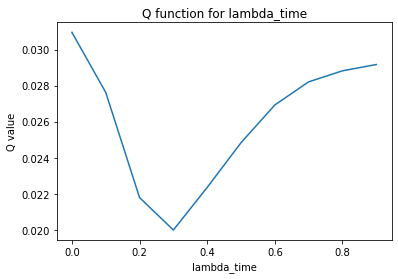

In [114]:
plt.plot(lambda_times,Q)
plt.xlabel('lambda_time')
plt.ylabel('Q value')
plt.title('Q function for lambda_time')
plt.show()

### Select lambad_nn

In [115]:
Q = []
lambda_nns = np.arange(0.001,0.05,0.051/10)
for lambda_nn in lambda_nns:
    lambda_time = 0.3
    lambda_unit = 1.2
    print(lambda_unit,lambda_time,lambda_nn)
    ATEs = Parallel(n_jobs=36, prefer='processes')(
                 delayed(get_ATE)(trial,Y_true,lambda_unit=lambda_unit,lambda_time=lambda_time,lambda_nn=lambda_nn)
                 for trial in range(100))
    Q.append(np.sqrt(np.mean(np.square(ATEs))))
    print(np.sqrt(np.mean(np.square(ATEs))))

1.2 0.3 0.001
0.023324308176910693
1.2 0.3 0.0060999999999999995
0.02020161101760189
1.2 0.3 0.011199999999999998
0.02056029463465725
1.2 0.3 0.0163
0.020110013811534714
1.2 0.3 0.0214
0.020011226368949295
1.2 0.3 0.0265
0.020233016857228267
1.2 0.3 0.031599999999999996
0.020446752164190483
1.2 0.3 0.036699999999999997
0.02062065749643188
1.2 0.3 0.0418
0.020792659222929607
1.2 0.3 0.0469
0.02095717273202653


In [116]:
lambda_nns[np.argmin(Q)]

0.0214

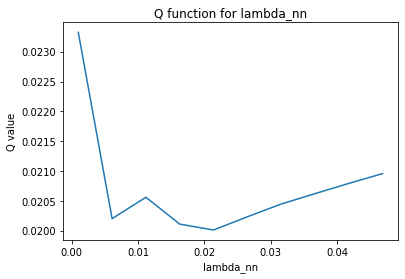

In [117]:
plt.plot(lambda_nns,Q)
plt.xlabel('lambda_nn')
plt.ylabel('Q value')
plt.title('Q function for lambda_nn')
plt.show()